# Constructing a Latent Dirichlet Allocation (LDA) Model

Install/Import Necessary Packages

In [ ]:
!pip install nltk
!pip install gensim
!pip install spacy
!pip install pyLDAvis

In [ ]:
import nltk
nltk.download("stopwords")
import numpy as np
import pandas as pd

#Using gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Using spacy
import spacy
from nltk.corpus import stopwords

#visualisation
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

#Get rid of annoying warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(42)

Text Pre-Processing

In [ ]:
df= pd.read_excel("/content/reviews.xlsx")
data = df["review_text"].tolist()
data[:5]

['Fit: GoodColour: GoodMaterial Quality: Very goodVery comfortable maternity wear. Highly recommended!',
 'Fit: comfortableColour: niceMaterial Quality: goodDelivery is very fast and quality is good!',
 'Material Quality: goodColour: niceNo regrets with this purchase. Can probably fit even post pregnancy as it is adjustable.',
 'Fit: 👍🏻Colour: 👍🏻Material Quality: no good quite thinQuick delivery.Item came in good condition.Value for money given the price that you are paying for.',
 'Material Quality: SoftColour: GreyFast delivery and worth buying with the promotions.']

In [ ]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
  nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
  #disabled these two because irrelevant, reduce comp load
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
      if token.pos_ in allowed_postags:
        new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return(texts_out)

lemmatized_texts = lemmatization(data)
print(lemmatized_texts[0:5][0:90])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


['fit very goodvery comfortable maternity wear highly recommend', 'nicematerial goodDelivery very fast quality good', 'regret purchase probably fit even post pregnancy adjustable', 'fit quality good quite thinquick delivery come good condition value money give price pay', 'delivery worth buy promotion']


In [ ]:
stopwords = stopwords.words("english")

def gen_words(texts):
  final = []
  for text in texts:
    if text not in stopwords:
      new = gensim.utils.simple_preprocess(text, deacc=True)
      final.append(new)
  return(final)

data_words = gen_words(lemmatized_texts)
print(data_words[0][0:20])

['fit', 'very', 'goodvery', 'comfortable', 'maternity', 'wear', 'highly', 'recommend']


In [ ]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=75)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=75)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['fit', 'very', 'goodvery', 'comfortable', 'maternity', 'wear', 'highly_recommend']


In [ ]:
id2word = corpora.Dictionary(data_words)
corpus = []
for text in data_words:
  new = id2word.doc2bow(text)
  corpus.append(new)

print(corpus[10][0:20])

word = id2word[[0][:1][0]]
print(word)

[(13, 1), (39, 1), (45, 1), (48, 1), (57, 1), (92, 1)]
comfortable


Coherence Analysis

In [ ]:
num_topics = 30
x = []
y = []

for i in range(num_topics):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i+1,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    x.append(i+1)
    y.append(cm.get_coherence())

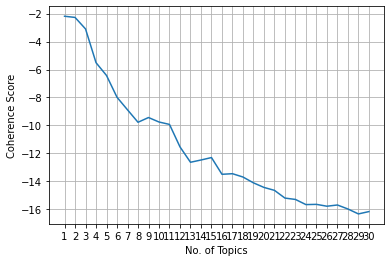

Optimal number of topics is 1 with a Coherence Score of -2.193158223828498


In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.grid()
plt.ylabel('Coherence Score')
plt.xlabel('No. of Topics')
plt.show()

num_topics = y.index(max(y))+1
print("Optimal number of topics is {} with a Coherence Score of {}".format(num_topics, max(y)))

Build LDA Model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=7,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha="auto")

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R = 30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.046113 -0.442687       1        1  31.231524
4     -0.423147  0.139456       2        1  24.081639
6      0.276590  0.308389       3        1  20.747691
2      0.377244 -0.132246       4        1   8.137281
3      0.104023 -0.054630       5        1   7.326374
0     -0.208860 -0.126037       6        1   4.536734
5     -0.079738  0.307757       7        1   3.938756, topic_info=          Term         Freq        Total Category  logprob  loglift
9         good  1120.000000  1120.000000  Default  30.0000  30.0000
200       nice   994.000000   994.000000  Default  29.0000  29.0000
12     quality   374.000000   374.000000  Default  28.0000  28.0000
179       size   617.000000   617.000000  Default  27.0000  27.0000
149      thank   592.000000   592.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1088   courier     6.355449     7.292299   Topic7  -5.1273   3.0968
1695  tomorrow     7.923255     9.153175   Topic7  -4.9068   3.0900
296      store     5.972681     6.907261   Topic7  -5.1894   3.0889
319      place     5.614626     6.542843   Topic7  -5.2513   3.0813
1654   palazzo     5.918732    14.474793   Topic7  -5.1985   2.3400

[261 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
226       1  0.987853        abit
230       3  0.982745        able
683       7  0.852189       about
357       6  0.964600  acceptable
717       4  0.957636      accord
...     ...       ...         ...
496       7  0.943205        wife
32        5  0.989453       worth
456       4  0.963947       wrong
1278      4  0.962170          xl
191       2  0.980595         yet

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 3, 4, 1, 6])

Tag Reviews to Dominant Topic Cluster

In [ ]:
optimal_model = lda_model
model_topics = optimal_model.show_topics(formatted=False)
#print(optimal_model.print_topics(num_words=10))

import matplotlib.pyplot as plt

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3433,"nice, material, very, wear, comfortable, buy, ...",Fit: GoodColour: GoodMaterial Quality: Very go...
1,1,4.0,0.2875,"good, thank, seller, delivery, fast, receive, ...",Fit: comfortableColour: niceMaterial Quality: ...
2,2,4.0,0.3794,"good, thank, seller, delivery, fast, receive, ...",Material Quality: goodColour: niceNo regrets w...
3,3,6.0,0.3648,"size, fit, big, kg, cm, too, month, get, pregn...",Fit: 👍🏻Colour: 👍🏻Material Quality: no good qui...
4,4,4.0,0.2588,"good, thank, seller, delivery, fast, receive, ...",Material Quality: SoftColour: GreyFast deliver...
5,5,4.0,0.4171,"good, thank, seller, delivery, fast, receive, ...",Items are nicely packed and received in good o...
6,6,1.0,0.5933,"nice, material, very, wear, comfortable, buy, ...","3rd purchase from seller. As usual, delivery i..."
7,7,4.0,0.4308,"good, thank, seller, delivery, fast, receive, ...",Ordered on 17/01 and received on 19/01. Super ...
8,8,1.0,0.6071,"nice, material, very, wear, comfortable, buy, ...",Fit: just niceColour: awesomeMaterial Quality:...
9,9,6.0,0.4670,"size, fit, big, kg, cm, too, month, get, pregn...",Fit: goodColour: goodMaterial Quality: better ...


In [ ]:
df_dominant_topic.to_csv("/content/df_dominant_topic.csv", index= False)